# Fitting a Transition Matrix with EM

We want to cluster cells into embryos with a Bayesian Mixture Model (BMM). Before running this model, we want to fit the transition matrix using Expectation Maximization (EM). Then, we can apply the model with one less unknown.

In [11]:
import pandas as pd
import anndata
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

## Load Data

Load the embryos and also filter out low UMI cells.

In [6]:
NUM_EMBRYOS = 3
UMI_CUTOFF = 2000

CALLS_SAVE_PATH = 'data/calls_2022_07_06.h5ad'
READS_SAVE_PATH = 'data/reads_2022_07_06.h5ad'

In [5]:
variants_joined = anndata.read_h5ad(CALLS_SAVE_PATH)
reads_joined = anndata.read_h5ad(READS_SAVE_PATH)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


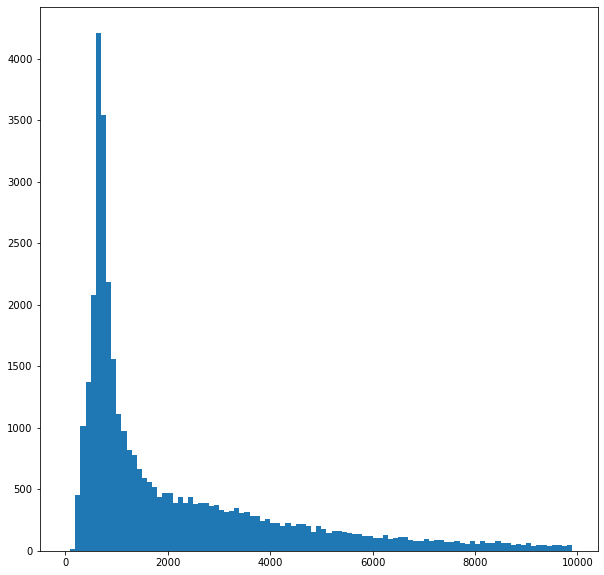

In [7]:
plt.figure(figsize=(10, 10))

umi_sum = reads_joined.X.sum(axis=1)
plt.hist(umi_sum, bins=range(0, 10000, 100))
plt.show()

In [8]:
cells_to_keep = umi_sum >= UMI_CUTOFF

variants_joined = variants_joined[cells_to_keep, :].copy()
reads_joined = reads_joined[cells_to_keep, :].copy()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [9]:
variants_joined.obs

,embryo
AAACCCAAGAAGAGCA-1,0
AAACCCAAGAGTTGAT-1,0
AAACCCAAGTGTTGTC-1,0
AAACCCACAAGGAGTC-1,0
AAACCCATCTTGGAAC-1,0
...,...
TTTGTTGGTGGCTGCT-1,2
TTTGTTGTCACCCTCA-1,2
TTTGTTGTCCACTTCG-1,2
TTTGTTGTCCTTTGAT-1,2


## Initialize Variables in the Model

In [10]:
# Our ground truth data
C = variants_joined.X
z = variants_joined.obs.embryo

In [16]:
# Initialize T according to the distributions we expect
alpha = np.array([[9, 0.33, 0.33, 0.33],
                  [4.5, 4.5, 0.5, 0.5],
                  [2.5, 2.5, 2.5, 2.5],
                  [4.5, 0.5, 0.5, 4.5]])

T = np.zeros((4, 4))

for k in range(T.shape[0]):
    T[k] = ss.dirichlet.rvs(alpha[k])

In [18]:
# Get gamma by finding the distribution of calls for each variant in each embryo
# gamma only has weight on zero if that variant has no non-zero calls
gamma_hists = []

# First find the histogram of calls for each variant for each embryo
for l in range(NUM_EMBRYOS):
    # Get a restricted dataset for our embryo
    variants_emb = variants_joined[variants_joined.obs.embryo == l, :]
    emb_hists = []
    
    for j in tqdm(range(variants_joined.shape[1])):
        variant_profile = variants_emb.X[:, j].flatten()
        hist = [np.sum(variant_profile == i) for i in range(4)]
        emb_hists.append(hist)
        
    gamma_hists.append(emb_hists)
    
gamma_hists = np.array(gamma_hists)

  0%|          | 0/27462 [00:00<?, ?it/s]

  0%|          | 0/27462 [00:00<?, ?it/s]

  0%|          | 0/27462 [00:00<?, ?it/s]

In [42]:
# Use the histograms to determine the embryo ground truth
pi = []

for l in range(NUM_EMBRYOS):
    pi_emb = []
    
    for hist in gamma_hists[l]:
        if hist[2] > 0:
            pi_emb.append(2)
        elif (hist[1] > 0) and (hist[3] == 0):
            pi_emb.append(1)
        elif (hist[3] > 0) and (hist[1] == 0):
            pi_emb.append(3)
        elif (hist[1] > 0) and (hist[3] > 0):
            pi_emb.append(2)
        else:
            pi_emb.append(0)
            
    pi.append(pi_emb)
    
pi = np.array(pi)

## Run EM Iterations

Due to our simplifications using the ground truth, we just need to optimize T. Since everything else is known, the optimization will finish in one step.

In [68]:
def get_transition_count(params):
    k1 = params[0]
    k2 = params[1]
    
    count = 0
    
    # Count the number of k1 -> k2 transitions
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            l = z[i]
            
            if pi[l][j] == k1 and C[i][j] == k2:
                count += 1
                
    
    # Add the prior
#     count += alpha[k1][k2]
#     count -= 1
    
    return count

In [69]:
from multiprocessing import Pool
from itertools import product

In [70]:
p = Pool(16)
params = list(product(*[range(4), range(4)]))

counts = list(p.map(get_transition_count, params))

p.close()

In [73]:
# Fill T with our new counts
for i, param in enumerate(params):
    k1 = param[0]
    k2 = param[1]
    
    T[k1][k2] = counts[i]
    
# Row normalize T
for i in range(T.shape[0]):
    T[i] = T[i]/np.sum(T[i])

/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [78]:
# Artificially set the fourth row of T based on the second
T[3][1] = 0
T[3][2] = 0
T[3][0] = T[1][0]
T[3][3] = T[1][1]

In [79]:
T

array([[1.        , 0.        , 0.        , 0.        ],
       [0.74778739, 0.25221261, 0.        , 0.        ],
       [0.84580846, 0.03814512, 0.10065051, 0.01539591],
       [0.74778739, 0.        , 0.        , 0.25221261]])